## Example (not directly related to optimization code)
#### gurobi.Multidict
```python
names, lower, upper = multidict({ ’x’: [0, 1], ’y’: [1, 2], ’z’: [0, 3] })
print(names)
[’x’, ’y’, ’z’]
print(lower)
{’x’: 0, ’y’: 1, ’z’: 0}
print(upper)
{’x’: 1, ’y’: 2, ’z’: 3}
```

#### Pandas MultiIndex from product
```python
A = (1,2,3)
K = (1,2)
pd.MultiIndex.from_product((A,A,K), names=("i", "j", "k"))
```

In [1]:

import sys
sys.dont_write_bytecode = True

import numpy as np
import pandas as pd
import graphviz
import gurobipy as gp
from gurobipy import GRB
sys.path.append("simulator")
from simulator import simulator as sim
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
import gurobipy_pandas as gppd
from gurobi_ml import add_predictor_constr
import matplotlib.pyplot as plt

random.seed(1234)

def trunc(temp): # utility function for node naming
    st = temp.find("(")
    temp = temp[:st]
    return temp

In [2]:
sim.three_depth_application()

User capacity: 99999999
A capacity: 33.333333333333336
B capacity: 100.0
C capacity: 40.0
D capacity: 25.0
E capacity: 33.333333333333336
F capacity: 100.0
- num_replica_for_cluster_0
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
- num_replica_for_cluster_1
	- User: 1
	- A: 2
	- B: 2
	- C: 2
	- D: 2
	- E: 2
	- F: 2
===== print_service_and_replica =====
User
	cluster 0 User_0(node[0000])
	cluster 1 User_1(node[1000])
A
	cluster 0 A_0(node[0000])
	cluster 0 A_2(node[0000])
	cluster 1 A_1(node[1000])
	cluster 1 A_3(node[1000])
B
	cluster 0 B_0(node[0000])
	cluster 0 B_2(node[0000])
	cluster 1 B_1(node[1000])
	cluster 1 B_3(node[1000])
C
	cluster 0 C_0(node[0000])
	cluster 0 C_2(node[0000])
	cluster 1 C_1(node[1000])
	cluster 1 C_3(node[1000])
D
	cluster 0 D_0(node[0000])
	cluster 0 D_2(node[0000])
	cluster 1 D_1(node[1000])
	cluster 1 D_3(node[1000])
E
	cluster 0 E_0(node[0000])
	cluster 0 E_2(node[0000])
	cluster 1 E_1(node[1000])
	cluster 1 E_3(node[1000])
F
	cluster 0 F_0(

(<simulator.simulator.Replica at 0x7ff099adbac0>,
 <simulator.simulator.Service at 0x7ff099adb820>)

## Predict the Service times


x_service_name
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A',

,service_name,rps,cpu,mem,compute_time
"(A_0_start, A_0_end)",A,0,0,0,1157.740568
"(A_0_start, A_0_end)",A,1,1,1,1980.780951
"(A_0_start, A_0_end)",A,2,2,2,477.134112
"(A_0_start, A_0_end)",A,3,3,3,1682.601685
"(A_0_start, A_0_end)",A,4,4,4,1112.271486
...,...,...,...,...,...
"(F_3_start, F_3_end)",F,95,95,95,10937.452965
"(F_3_start, F_3_end)",F,96,96,96,11027.922964
"(F_3_start, F_3_end)",F,97,97,97,10515.980006
"(F_3_start, F_3_end)",F,98,98,98,9730.742843


The R^2 value in the test set is 0.96282


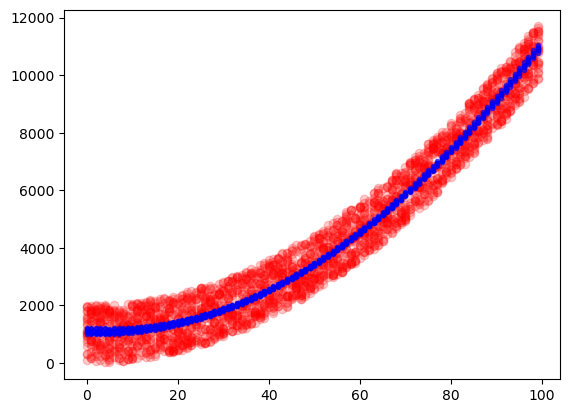

In [62]:
true_function_degree = 2
regressor_degree = 2
num_data_point = 100 # fake observation data point per service
randomize_factor = 2000
x_rps = list()
x_cpu = list()
x_service_name = list()
y_compute_time = list()
svc_name_list = list()

compute_arc_var_name = list()
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        # var_name = trunc(repl.to_str())+"_start" + "_" + trunc(repl.to_str())+"_end"
        var_name = (trunc(repl.to_str())+"_start", trunc(repl.to_str())+"_end")
        compute_arc_var_name.append(var_name)
        svc_name_list.append(repl.service.name)

network_arc_var_name = list()
for parent_repl in sim.dag.child_replica:
    for child_svc in sim.dag.child_replica[parent_repl]:
        child_repl_list = sim.dag.child_replica[parent_repl][child_svc]
        for child_repl in child_repl_list:
            if parent_repl.service.name == "User":
                # var_name = "src_*_*" + "_" + trunc(child_repl.to_str())+"_start"
                var_name = ("src_*_*", trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            else:
                # var_name = trunc(parent_repl.to_str())+"_end" + "_" + trunc(child_repl.to_str())+"_start"
                var_name = (trunc(parent_repl.to_str())+"_end",  trunc(child_repl.to_str())+"_start")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)
            if sim.dag.is_leaf(child_repl.service):
                # var_name = trunc(child_repl.to_str())+"_end" + "_" + "dst_*_*"
                var_name = (trunc(child_repl.to_str())+"_end", "dst_*_*")
                if var_name not in network_arc_var_name:
                    network_arc_var_name.append(var_name)

other_arc_var_name = list()
for repl in sim.dag.all_replica:
    if sim.dag.is_leaf(repl.service):
        other_arc_var_name.append(trunc(repl.to_str())+"_end" + "_" + "dst_*_*")
# for v in network_arc_var_name:
#     print(v)
# print("compute_arc_var: ", len(compute_arc_var_name))
# print("network_arc_var: ", len(network_arc_var_name))
# print("other_arc_var_name: ", len(other_arc_var_name))
# print("total_arc_var: ", len(compute_arc_var_name) + len(network_arc_var_name) + len(other_arc_var_name))
total_var_name = compute_arc_var_name + network_arc_var_name + other_arc_var_name
x_repl_name = list()
for i in range(len(compute_arc_var_name)):
    x_rps += list(np.arange(0,num_data_point))
    x_cpu += list(np.arange(0,num_data_point))
    x_repl_name += [compute_arc_var_name[i]] * num_data_point
    x_service_name += svc_name_list[i] * num_data_point

print("x_service_name")
print(x_service_name)

for _ in compute_arc_var_name:
    for i in range(num_data_point):
        y_compute_time.append(pow(x_rps[i],true_function_degree) + random.random()*randomize_factor)
        # y_compute_time.append(pow(x_rps[i],true_function_degree) + x_cpu[i] + random.random()*randomize_factor)
    
print(len(x_rps))
print(len(x_cpu))
print(len(x_repl_name))
print(len(x_service_name))
print(len(y_compute_time))

compute_time_observation = pd.DataFrame(
    data={
        "service_name": x_service_name,
        "rps": x_rps, 
        "cpu": x_cpu, 
        "mem": x_cpu, 
        "compute_time": y_compute_time,
    },
    index=x_repl_name
)

# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(compute_time_observation)
print("compute_time_observation df")
display(compute_time_observation)

X = compute_time_observation[["service_name", "rps", "cpu", "mem"]]
# X = compute_time_observation[["service_name", "rps", "cpu"]]
# X = compute_time_observation[["service_name", "rps"]]
y = compute_time_observation["compute_time"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=1
)

    # (StandardScaler(), ["rps", "cpu"]),
    # ("passthrough", ["rps"]),
    
feat_transform = make_column_transformer(
    (OneHotEncoder(), ["service_name"]),
    (StandardScaler(), ["rps", "cpu", "mem"]),
    verbose_feature_names_out=False,
    remainder='drop'
)

## Pipeline consists of
## 1. trasformation of input feature
## 2. training the model using X_train, y_train dataset
if regressor_degree == 1:
    reg = make_pipeline(feat_transform, LinearRegression())
    reg.fit(X_train, y_train)
elif regressor_degree > 1:
    poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    reg = make_pipeline(feat_transform, poly, LinearRegression())
    reg.fit(X_train, y_train)
    #################################################
    ## Break down polynomial regressor pipeline ##
    #################################################
    # print("Original X_train: ", X_train)
    # X_train_T = feat_transform.fit_transform(X_train)
    # print("X_train_T: ", X_train_T)
    # poly = PolynomialFeatures(degree=regressor_degree, include_bias=True)
    # X_train_poly = poly.fit_transform(X_train_T)
    # print("X_train_poly: ", X_train_poly)
    # reg = LinearRegression()
    # reg.fit(X_train_poly, y_train)
    # print("poly.get_feature_names_out(): ", poly.get_feature_names_out())

## Debug print
# print(reg[0])
# print(reg[1])
# print(reg)

## Print trained parameters(coefficients) of the model
# print("Coefficients of linear regression model: ", reg["linearregression"].coef_)

## Run prediction and compare it with the ground truth to see how accurate the trained model is
y_pred = reg.predict(X_test)
print(f"The R^2 value in the test set is {np.round(r2_score(y_test, y_pred),5)}")
plt.plot(X["rps"], y, 'ro', label="compute_time_observation", alpha=0.2)
plt.plot(X["rps"], reg.predict(X), 'b.', label="compute_time_observation", alpha=0.2)
plt.show()

In [63]:
temp = feat_transform.fit_transform(X_train)
display(pd.DataFrame(temp))

,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,0.0,1.0,0.0,1.714234,1.714234,1.714234
1,0.0,0.0,0.0,0.0,0.0,1.0,0.707605,0.707605,0.707605
2,1.0,0.0,0.0,0.0,0.0,0.0,0.499337,0.499337,0.499337
3,0.0,0.0,0.0,1.0,0.0,0.0,-0.403158,-0.403158,-0.403158
4,0.0,0.0,1.0,0.0,0.0,0.0,-0.437869,-0.437869,-0.437869
...,...,...,...,...,...,...,...,...,...
1915,0.0,0.0,0.0,0.0,1.0,0.0,0.360492,0.360492,0.360492
1916,0.0,0.0,0.0,0.0,1.0,0.0,-1.548632,-1.548632,-1.548632
1917,0.0,0.0,0.0,0.0,0.0,1.0,1.610100,1.610100,1.610100
1918,0.0,1.0,0.0,0.0,0.0,0.0,-0.507292,-0.507292,-0.507292


## Optimize latency for num of requests

Notation for the formulation of the mathematical optimization model.
The subscript $s$ will be used to denote each region.
### Input parameters
- $ServiceTime(r)$: predicted service time of service $s$ when rps is $r$. (~~asdf$ServiceTime(r, c, m, s)$ cpu util is $c$, memory util is $m$~~.)
- $r^s_{min}$: minimum rps for service $s$
- $r^s_{max}$: maximum rps for service $s$

cpu and mem are **Not** being used
- $c^s_{min}$: minimum cpu util for service $s$
- $c^s_{max}$: maximum cpu util for service $s$
- $m^s_{min}$: minimum memory util for service $s$
- $m^s_{max}$: maximum memory util for service $s$

## Decision Variables
(A decision variable is an unknown in an optimization problem.)

- $num\ request$: inbound number of request to *User*
  
- $rps^{dst}_{src}$: number of request from src to dst

- $service\ time^{dst}_{src}(r)$: **predicted** service time from $src$ to $dst$ in $arcs$ gurobi variable when $rps^{dst}_{src}$ is $r$.

  $rps$ is inbound flow into dst node which is represented by $flow$ variable later.
        
- $network\ latency^{dst}_{src}$: network latency between $src$ and $dst$ in $arcs$ gurobi variable. 
        
  It is fixed value. (It is not determineded yet that it should be RTT or one-way latency.)
  

In [73]:
min_cpu = 0
max_cpu = 100
min_rps = 0
max_rps = GRB.INFINITY

target_var = compute_arc_var_name
min_compute_time = [0] * len(target_var)
max_compute_time = [GRB.INFINITY] * len(target_var) # SLO
compute_time_data = pd.DataFrame(
    data={
        # "service_name":target_var,
        "min_cpu":[min_cpu]*len(target_var),
        "max_cpu":[max_cpu]*len(target_var),
        "min_mem":[min_cpu]*len(target_var),
        "max_mem":[max_cpu]*len(target_var),
        "min_rps":[min_rps]*len(target_var),
        "max_rps":[max_rps]*len(target_var),
        "min_compute_time": min_compute_time,
        "max_compute_time": max_compute_time,
    },
    index=target_var
)

target_var = network_arc_var_name
min_network_latency = list()
max_network_latency = list()
for src_repl, dst_repl in network_arc_var_name:
    print("src_repl: ", src_repl)
    print("dst_repl: ", dst_repl)
    src_svc = src_repl.split("_")[0]
    dst_svc = dst_repl.split("_")[0]
    if src_svc == "src":
        min_network_latency.append(0)
        max_network_latency.append(0)
    elif dst_svc == "dst":
        min_network_latency.append(0)
        max_network_latency.append(0)
    else:
        from_idx = int(src_repl.split("_")[1])
        to_idx = int(dst_repl.split("_")[1])
        if from_idx%2 == to_idx%2:
            min_network_latency.append(sim.NetworkLatency().same_rack)
            max_network_latency.append(sim.NetworkLatency().same_rack)
        else:
            min_network_latency.append(sim.NetworkLatency().far_inter_region)
            max_network_latency.append(sim.NetworkLatency().far_inter_region)
network_latency_data = pd.DataFrame(
    data={
        # "service_name":target_var,
        "min_rps":[min_rps]*len(target_var),
        "max_rps":[max_rps]*len(target_var),
        "min_network_latency": min_network_latency,
        "max_network_latency": max_network_latency,
    },
    index=target_var
)

# display(compute_time_data)

# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
display(network_latency_data)

src_repl:  src_*_*
dst_repl:  A_0_start
src_repl:  src_*_*
dst_repl:  A_2_start
src_repl:  src_*_*
dst_repl:  A_1_start
src_repl:  src_*_*
dst_repl:  A_3_start
src_repl:  A_0_end
dst_repl:  B_0_start
src_repl:  B_0_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  B_2_start
src_repl:  B_2_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  B_1_start
src_repl:  B_1_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  B_3_start
src_repl:  B_3_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  C_0_start
src_repl:  C_0_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  C_2_start
src_repl:  C_2_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  C_1_start
src_repl:  C_1_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  C_3_start
src_repl:  C_3_end
dst_repl:  dst_*_*
src_repl:  A_0_end
dst_repl:  D_0_start
src_repl:  A_0_end
dst_repl:  D_2_start
src_repl:  A_0_end
dst_repl:  D_1_start
src_repl:  A_0_end
dst_repl:  D_3_start
src_repl:  A_2_end
dst_repl:  B_0_start
src_repl:  A_2_e

,min_rps,max_rps,min_network_latency,max_network_latency
"(src_*_*, A_0_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_2_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_1_start)",0,1.000000e+100,0.0,0.0
"(src_*_*, A_3_start)",0,1.000000e+100,0.0,0.0
"(A_0_end, B_0_start)",0,1.000000e+100,0.5,0.5
...,...,...,...,...
"(D_3_end, E_3_start)",0,1.000000e+100,0.5,0.5
"(D_3_end, F_0_start)",0,1.000000e+100,30.0,30.0
"(D_3_end, F_2_start)",0,1.000000e+100,30.0,30.0
"(D_3_end, F_1_start)",0,1.000000e+100,0.5,0.5


## gurobi constant var
The best way to handle this on your end is to simply set the lower and upper bounds of those variables to the same value.

In [75]:
model = gp.Model('RequestRouting')

# Add variables for the regression
compute_time = gppd.add_vars(model, compute_time_data, name="compute_time", lb="min_compute_time", ub="max_compute_time")

cpu = gppd.add_vars(model, compute_time_data, name="cpu", lb="min_cpu", ub="max_cpu")

mem = gppd.add_vars(model, compute_time_data, name="mem", lb="min_mem", ub="max_mem")

compute_rps = gppd.add_vars(model, compute_time_data, name="rps_for_compute_edge", lb="min_rps", ub="max_rps")
model.update()

m_feats = pd.DataFrame(
    data={
        # "service_name": compute_arc_var_name,
        "service_name": svc_name_list,
        "rps": compute_rps,
        "cpu": cpu,
        "mem": mem,
    },
    index=compute_arc_var_name
)
display(m_feats)
display(compute_time)
pred_constr = add_predictor_constr(model, reg, m_feats, compute_time)
pred_constr.print_stats()
model.update()

,service_name,rps,cpu,mem
"(A_0_start, A_0_end)",A,"<gurobi.Var rps_for_compute_edge[('A_0_start',...","<gurobi.Var cpu[('A_0_start',_'A_0_end')]>","<gurobi.Var mem[('A_0_start',_'A_0_end')]>"
"(A_2_start, A_2_end)",A,"<gurobi.Var rps_for_compute_edge[('A_2_start',...","<gurobi.Var cpu[('A_2_start',_'A_2_end')]>","<gurobi.Var mem[('A_2_start',_'A_2_end')]>"
"(B_0_start, B_0_end)",B,"<gurobi.Var rps_for_compute_edge[('B_0_start',...","<gurobi.Var cpu[('B_0_start',_'B_0_end')]>","<gurobi.Var mem[('B_0_start',_'B_0_end')]>"
"(B_2_start, B_2_end)",B,"<gurobi.Var rps_for_compute_edge[('B_2_start',...","<gurobi.Var cpu[('B_2_start',_'B_2_end')]>","<gurobi.Var mem[('B_2_start',_'B_2_end')]>"
"(C_0_start, C_0_end)",C,"<gurobi.Var rps_for_compute_edge[('C_0_start',...","<gurobi.Var cpu[('C_0_start',_'C_0_end')]>","<gurobi.Var mem[('C_0_start',_'C_0_end')]>"
"(C_2_start, C_2_end)",C,"<gurobi.Var rps_for_compute_edge[('C_2_start',...","<gurobi.Var cpu[('C_2_start',_'C_2_end')]>","<gurobi.Var mem[('C_2_start',_'C_2_end')]>"
"(D_0_start, D_0_end)",D,"<gurobi.Var rps_for_compute_edge[('D_0_start',...","<gurobi.Var cpu[('D_0_start',_'D_0_end')]>","<gurobi.Var mem[('D_0_start',_'D_0_end')]>"
"(D_2_start, D_2_end)",D,"<gurobi.Var rps_for_compute_edge[('D_2_start',...","<gurobi.Var cpu[('D_2_start',_'D_2_end')]>","<gurobi.Var mem[('D_2_start',_'D_2_end')]>"
"(E_0_start, E_0_end)",E,"<gurobi.Var rps_for_compute_edge[('E_0_start',...","<gurobi.Var cpu[('E_0_start',_'E_0_end')]>","<gurobi.Var mem[('E_0_start',_'E_0_end')]>"
"(E_2_start, E_2_end)",E,"<gurobi.Var rps_for_compute_edge[('E_2_start',...","<gurobi.Var cpu[('E_2_start',_'E_2_end')]>","<gurobi.Var mem[('E_2_start',_'E_2_end')]>"


(A_0_start, A_0_end)    <gurobi.Var compute_time[('A_0_start',_'A_0_en...
(A_2_start, A_2_end)    <gurobi.Var compute_time[('A_2_start',_'A_2_en...
(B_0_start, B_0_end)    <gurobi.Var compute_time[('B_0_start',_'B_0_en...
(B_2_start, B_2_end)    <gurobi.Var compute_time[('B_2_start',_'B_2_en...
(C_0_start, C_0_end)    <gurobi.Var compute_time[('C_0_start',_'C_0_en...
(C_2_start, C_2_end)    <gurobi.Var compute_time[('C_2_start',_'C_2_en...
(D_0_start, D_0_end)    <gurobi.Var compute_time[('D_0_start',_'D_0_en...
(D_2_start, D_2_end)    <gurobi.Var compute_time[('D_2_start',_'D_2_en...
(E_0_start, E_0_end)    <gurobi.Var compute_time[('E_0_start',_'E_0_en...
(E_2_start, E_2_end)    <gurobi.Var compute_time[('E_2_start',_'E_2_en...
(F_0_start, F_0_end)    <gurobi.Var compute_time[('F_0_start',_'F_0_en...
(F_2_start, F_2_end)    <gurobi.Var compute_time[('F_2_start',_'F_2_en...
(A_1_start, A_1_end)    <gurobi.Var compute_time[('A_1_start',_'A_1_en...
(A_3_start, A_3_end)    <gurobi.Var co

Model for pipe:
1536 variables
96 constraints
1320 quadratic constraints
Input has shape (24, 4)
Output has shape (24, 1)

Pipeline has 3 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
col_trans            (24, 9)           72           72            0            0

poly_feat           (24, 55)         1464            0         1320            0

lin_reg              (24, 1)            0           24            0            0

--------------------------------------------------------------------------------


In [76]:
network_latency = gppd.add_vars(model, network_latency_data, name="network_latency", lb="min_network_latency", ub="max_network_latency")

network_rps = gppd.add_vars(model, network_latency_data, name="rps_for_network_edge", lb="min_rps", ub="max_rps")

model.update()

print(type(network_latency))
print(network_latency)
print(network_rps)

<class 'pandas.core.series.Series'>
(src_*_*, A_0_start)    <gurobi.Var network_latency[('src____',_'A_0_s...
(src_*_*, A_2_start)    <gurobi.Var network_latency[('src____',_'A_2_s...
(src_*_*, A_1_start)    <gurobi.Var network_latency[('src____',_'A_1_s...
(src_*_*, A_3_start)    <gurobi.Var network_latency[('src____',_'A_3_s...
(A_0_end, B_0_start)    <gurobi.Var network_latency[('A_0_end',_'B_0_s...
                                              ...                        
(D_3_end, E_3_start)    <gurobi.Var network_latency[('D_3_end',_'E_3_s...
(D_3_end, F_0_start)    <gurobi.Var network_latency[('D_3_end',_'F_0_s...
(D_3_end, F_2_start)    <gurobi.Var network_latency[('D_3_end',_'F_2_s...
(D_3_end, F_1_start)    <gurobi.Var network_latency[('D_3_end',_'F_1_s...
(D_3_end, F_3_start)    <gurobi.Var network_latency[('D_3_end',_'F_3_s...
Name: network_latency, Length: 100, dtype: object
(src_*_*, A_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'...
(src_*_*, A_2_start)    <g

In [77]:
# print("="*30 + " var: service time " + "="*30)
# print(compute_time)
# print("="*30 + " var: rps " + "="*30)
# print(rps)
# print("="*30 + " var: network latency " + "="*30)
# print(network_latency)

print("="*30 + " model object " + "="*30)
print("len(model.getVars()): ", len(model.getVars()))
# print("model.getVars(): ", model_vars)
model_vars = model.getVars()
for v in model_vars:
    print(v)

============================== model object ==============================
len(model.getVars()):  1832
<gurobi.Var compute_time[('A_0_start',_'A_0_end')]>
<gurobi.Var compute_time[('A_2_start',_'A_2_end')]>
<gurobi.Var compute_time[('B_0_start',_'B_0_end')]>
<gurobi.Var compute_time[('B_2_start',_'B_2_end')]>
<gurobi.Var compute_time[('C_0_start',_'C_0_end')]>
<gurobi.Var compute_time[('C_2_start',_'C_2_end')]>
<gurobi.Var compute_time[('D_0_start',_'D_0_end')]>
<gurobi.Var compute_time[('D_2_start',_'D_2_end')]>
<gurobi.Var compute_time[('E_0_start',_'E_0_end')]>
<gurobi.Var compute_time[('E_2_start',_'E_2_end')]>
<gurobi.Var compute_time[('F_0_start',_'F_0_end')]>
<gurobi.Var compute_time[('F_2_start',_'F_2_end')]>
<gurobi.Var compute_time[('A_1_start',_'A_1_end')]>
<gurobi.Var compute_time[('A_3_start',_'A_3_end')]>
<gurobi.Var compute_time[('B_1_start',_'B_1_end')]>
<gurobi.Var compute_time[('B_3_start',_'B_3_end')]>
<gurobi.Var compute_time[('C_1_start',_'C_1_end')]>
<gurobi.Var c

In [52]:
## obj argument in AddVars: 
# - coefficient of the varianbel in the objective function
# - Note that this attribute interacts with our piecewise-linear objective feature
# - you typically use the setObjective method to set the objective, but this attribute provides an alternative for setting or modifying linear objective terms.
# - ** The default sense for the objective function is minimization. 

## reference for obj: 
# - https://www.gurobi.com/documentation/current/refman/obj.html#attr:Obj
# - https://stackoverflow.com/questions/65782751/gurobi-using-the-obj-parameter-from-addvar

# flow = model.addVars(arcs, name="flow")
# model.update()

## why is the default objective function sum of minimum of (compute_time or network latency)*flow
# flow = model.addVars(arcs, obj=latency, name="flow") 

In [79]:
network_latency_sum = sum(network_latency.multiply(network_rps))
compute_latency_sum = sum(compute_time.multiply(m_feats["rps"]))
# with pd.option_context('display.max_colwidth', None):
#     display(network_latency_sum)
#     display(compute_latency_sum)

total_latency_sum = compute_latency_sum + network_latency_sum
model.setObjective(total_latency_sum, gp.GRB.MINIMIZE)
model.update()

print("model objective")
print(model.getObjective())

model objective
0.0 + [ compute_time[('A_0_start',_'A_0_end')] * rps_for_compute_edge[('A_0_start',_'A_0_end')] + compute_time[('A_2_start',_'A_2_end')] * rps_for_compute_edge[('A_2_start',_'A_2_end')] + compute_time[('B_0_start',_'B_0_end')] * rps_for_compute_edge[('B_0_start',_'B_0_end')] + compute_time[('B_2_start',_'B_2_end')] * rps_for_compute_edge[('B_2_start',_'B_2_end')] + compute_time[('C_0_start',_'C_0_end')] * rps_for_compute_edge[('C_0_start',_'C_0_end')] + compute_time[('C_2_start',_'C_2_end')] * rps_for_compute_edge[('C_2_start',_'C_2_end')] + compute_time[('D_0_start',_'D_0_end')] * rps_for_compute_edge[('D_0_start',_'D_0_end')] + compute_time[('D_2_start',_'D_2_end')] * rps_for_compute_edge[('D_2_start',_'D_2_end')] + compute_time[('E_0_start',_'E_0_end')] * rps_for_compute_edge[('E_0_start',_'E_0_end')] + compute_time[('E_2_start',_'E_2_end')] * rps_for_compute_edge[('E_2_start',_'E_2_end')] + compute_time[('F_0_start',_'F_0_end')] * rps_for_compute_edge[('F_0_start',_

In [126]:
arcs, aggregated_rps = gp.multidict(pd.concat([network_rps, compute_rps], axis=0).to_dict())
with pd.option_context('display.max_colwidth', None):
    # print("<network_latency>")
    # print(network_latency.head())
    # print("<compute_time>")
    # print(compute_time.head())
    print("<network_rps>")
    print(network_rps.head())
    print("<compute_rps>")
    print(compute_rps.head())
    print("<aggregated_rps>")
    print(type(aggregated_rps))
    print(aggregated_rps)

<network_rps>
(src_*_*, A_0_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_0_start')]>
(src_*_*, A_2_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_2_start')]>
(src_*_*, A_1_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_1_start')]>
(src_*_*, A_3_start)    <gurobi.Var rps_for_network_edge[('src____',_'A_3_start')]>
(A_0_end, B_0_start)    <gurobi.Var rps_for_network_edge[('A_0_end',_'B_0_start')]>
Name: rps_for_network_edge, dtype: object
<compute_rps>
(A_0_start, A_0_end)    <gurobi.Var rps_for_compute_edge[('A_0_start',_'A_0_end')]>
(A_2_start, A_2_end)    <gurobi.Var rps_for_compute_edge[('A_2_start',_'A_2_end')]>
(B_0_start, B_0_end)    <gurobi.Var rps_for_compute_edge[('B_0_start',_'B_0_end')]>
(B_2_start, B_2_end)    <gurobi.Var rps_for_compute_edge[('B_2_start',_'B_2_end')]>
(C_0_start, C_0_end)    <gurobi.Var rps_for_compute_edge[('C_0_start',_'C_0_end')]>
Name: rps_for_compute_edge, dtype: object
<aggregated_rps>
<class 'gurobipy.tupledict'>
{(

In [116]:
NUM_REQUEST = [100, 100]
TOTAL_NUM_REQUEST = sum(NUM_REQUEST)
source = dict()
destination = dict()
source["src_*_*"] = TOTAL_NUM_REQUEST
destination["dst_*_*"] = TOTAL_NUM_REQUEST

node = dict()
max_tput = TOTAL_NUM_REQUEST
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        node[trunc(repl.to_str())+"_start"] = max_tput
        node[trunc(repl.to_str())+"_end"] = max_tput

print(node)

{'A_0_start': 200, 'A_0_end': 200, 'A_2_start': 200, 'A_2_end': 200, 'B_0_start': 200, 'B_0_end': 200, 'B_2_start': 200, 'B_2_end': 200, 'C_0_start': 200, 'C_0_end': 200, 'C_2_start': 200, 'C_2_end': 200, 'D_0_start': 200, 'D_0_end': 200, 'D_2_start': 200, 'D_2_end': 200, 'E_0_start': 200, 'E_0_end': 200, 'E_2_start': 200, 'E_2_end': 200, 'F_0_start': 200, 'F_0_end': 200, 'F_2_start': 200, 'F_2_end': 200, 'A_1_start': 200, 'A_1_end': 200, 'A_3_start': 200, 'A_3_end': 200, 'B_1_start': 200, 'B_1_end': 200, 'B_3_start': 200, 'B_3_end': 200, 'C_1_start': 200, 'C_1_end': 200, 'C_3_start': 200, 'C_3_end': 200, 'D_1_start': 200, 'D_1_end': 200, 'D_3_start': 200, 'D_3_end': 200, 'E_1_start': 200, 'E_1_end': 200, 'E_3_start': 200, 'E_3_end': 200, 'F_1_start': 200, 'F_1_end': 200, 'F_3_start': 200, 'F_3_end': 200}


In [109]:
# Constraint 1: source
src_keys = source.keys()
src_flow = model.addConstrs((gp.quicksum(aggregated_rps.select(src, '*')) == source[src] for src in src_keys), name="source")

model.update()

In [111]:
# Constraint 2: destination
dest_keys = destination.keys()
num_leaf_svc = 0
leaf_svc = list()
for svc in sim.dag.all_service:
    # print("iterate ", svc.name)
    if sim.dag.is_leaf(svc):
        num_leaf_svc += 1
        leaf_svc.append(svc.name)
print("leaf_svc: ", leaf_svc)
print("num_leaf_svc: ", num_leaf_svc)
dst_flow = model.addConstrs((gp.quicksum(aggregated_rps.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

model.update()

leaf_svc:  ['B', 'C', 'E', 'F']
num_leaf_svc:  4


In [118]:
# Constraint 3: flow conservation
for repl in sim.dag.all_replica:
    if repl.service.name != "User":
        # Start node in-out flow conservation
        st = trunc(repl.to_str())+"_start"
        node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', st)) == gp.quicksum(aggregated_rps.select(st, '*'))), name="flow_conservation["+st+"]")
        # End node in-out flow conservation
        en = trunc(repl.to_str())+"_end"
        if sim.dag.is_leaf(repl.service):
            node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == gp.quicksum(aggregated_rps.select(en, '*'))), name="flow_conservation["+en+"]")
        else:
            for child_svc in repl.child_services:
                out_sum = 0
                for child_repl in child_svc.replicas:
                    child_repl_name = trunc(child_repl.to_str()) + "_start"
                    out_sum += aggregated_rps.sum(en, child_repl_name)
                node_flow = model.addConstr((gp.quicksum(aggregated_rps.select('*', en)) == out_sum), name="flow_conservation["+en+"]")
model.update()

In [119]:
# Constraint 4: Tree topology
for svc in sim.dag.all_service:
    if svc.name != "User":
        svc_repl = svc.replicas
        sum_ = 0
        for repl in svc_repl:
            repl_name = trunc(repl.to_str()) + "_start"
            sum_ += aggregated_rps.sum('*', repl_name)
        #     print("repl_name:", repl_name)
        #     print("aggregated_rps.sum('*', repl_name):", aggregated_rps.sum('*', repl_name))
        # print("flow sum ({}): {}".format(svc.name, sum_))
        node_flow = model.addConstr(sum_ == TOTAL_NUM_REQUEST, name="tree_topo_conservation")
        # print()
model.update()

In [120]:
# Constraint 5: max throughput of service
node_key = node.keys()
throughput = model.addConstrs((gp.quicksum(aggregated_rps.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")
model.update()

In [123]:
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
with pd.option_context('display.max_rows', None,):
    with pd.option_context('display.max_colwidth', None):
        print(df_constr.shape)
        display(df_constr.tail(20))
df_constr.to_csv("constraint.csv")

(280, 4)


,Constraint Name,Constraint equation,Sense,RHS
260,service_capacity[B_1_start],"rps_for_network_edge[('A_0_end',_'B_1_start')] + rps_for_network_edge[('A_2_end',_'B_1_start')] + rps_for_network_edge[('A_1_end',_'B_1_start')] + rps_for_network_edge[('A_3_end',_'B_1_start')]",<,200.0
261,service_capacity[B_1_end],"rps_for_compute_edge[('B_1_start',_'B_1_end')]",<,200.0
262,service_capacity[B_3_start],"rps_for_network_edge[('A_0_end',_'B_3_start')] + rps_for_network_edge[('A_2_end',_'B_3_start')] + rps_for_network_edge[('A_1_end',_'B_3_start')] + rps_for_network_edge[('A_3_end',_'B_3_start')]",<,200.0
263,service_capacity[B_3_end],"rps_for_compute_edge[('B_3_start',_'B_3_end')]",<,200.0
264,service_capacity[C_1_start],"rps_for_network_edge[('A_0_end',_'C_1_start')] + rps_for_network_edge[('A_2_end',_'C_1_start')] + rps_for_network_edge[('A_1_end',_'C_1_start')] + rps_for_network_edge[('A_3_end',_'C_1_start')]",<,200.0
265,service_capacity[C_1_end],"rps_for_compute_edge[('C_1_start',_'C_1_end')]",<,200.0
266,service_capacity[C_3_start],"rps_for_network_edge[('A_0_end',_'C_3_start')] + rps_for_network_edge[('A_2_end',_'C_3_start')] + rps_for_network_edge[('A_1_end',_'C_3_start')] + rps_for_network_edge[('A_3_end',_'C_3_start')]",<,200.0
267,service_capacity[C_3_end],"rps_for_compute_edge[('C_3_start',_'C_3_end')]",<,200.0
268,service_capacity[D_1_start],"rps_for_network_edge[('A_0_end',_'D_1_start')] + rps_for_network_edge[('A_2_end',_'D_1_start')] + rps_for_network_edge[('A_1_end',_'D_1_start')] + rps_for_network_edge[('A_3_end',_'D_1_start')]",<,200.0
269,service_capacity[D_1_end],"rps_for_compute_edge[('D_1_start',_'D_1_end')]",<,200.0


In [124]:
# # Constraint 1: source
# src_keys = source.keys()
# src_flow = model.addConstrs((gp.quicksum(flow.select(src, '*')) == source[src] for src in src_keys), name="source")

# # Constraint 2: destination
# dest_keys = destination.keys()
# num_leaf_svc = 0
# leaf_svc = list()
# for svc in sim.dag.all_service:
#     # print("iterate ", svc.name)
#     if sim.dag.is_leaf(svc):
#         num_leaf_svc += 1
#         leaf_svc.append(svc.name)
# print("leaf_svc: ", leaf_svc)
# print("num_leaf_svc: ", num_leaf_svc)
# dst_flow = model.addConstrs((gp.quicksum(flow.select('*', dst)) == destination[dst]*num_leaf_svc for dst in dest_keys), name="destination")

# # Constraint 3: flow conservation
# # node_key = node.keys()
# # node_flow = model.addConstrs((gp.quicksum(flow.select('*', n_)) == gp.quicksum(flow.select(n_, '*')) for n_ in node_key), name="flow_conservation")
# for repl in sim.dag.all_replica:
#     if repl.service.name != "User":
#         # Start node in-out flow conservation
#         st = trunc(repl.to_str())+"_start"
#         node_flow = model.addConstr((gp.quicksum(flow.select('*', st)) == gp.quicksum(flow.select(st, '*'))), name="flow_conservation["+st+"]")
#         # End node in-out flow conservation
#         en = trunc(repl.to_str())+"_end"
#         if sim.dag.is_leaf(repl.service):
#             node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == gp.quicksum(flow.select(en, '*'))), name="flow_conservation["+en+"]")
#         else:
#             for child_svc in repl.child_services:
#                 out_sum = 0
#                 for child_repl in child_svc.replicas:
#                     child_repl_name = trunc(child_repl.to_str()) + "_start"
#                     out_sum += flow.sum(en, child_repl_name)
#                 node_flow = model.addConstr((gp.quicksum(flow.select('*', en)) == out_sum), name="flow_conservation["+en+"]")

# # Constraint 4: Tree topology
# for svc in sim.dag.all_service:
#     if svc.name != "User":
#         svc_repl = svc.replicas
#         sum_ = 0
#         for repl in svc_repl:
#             repl_name = trunc(repl.to_str()) + "_start"
#             sum_ += flow.sum('*', repl_name)
#         #     print("repl_name:", repl_name)
#         #     print("flow.sum('*', repl_name):", flow.sum('*', repl_name))
#         # print("flow sum ({}): {}".format(svc.name, sum_))
#         node_flow = model.addConstr(sum_ == total_num_request, name="tree_topo_conservation")
#         # print()

# # Constraint 5: max throughput of service
# node_key = node.keys()
# throughput = model.addConstrs((gp.quicksum(flow.select('*', n_)) <= node[n_] for n_ in node_key), name="service_capacity")

In [127]:
##############################################################################
model.optimize()

# Variable info
varInfo = [(v.varName, v.LB, v.UB) for v in model.getVars() ] # use list comprehension
df_var = pd.DataFrame(varInfo) # convert to pandas dataframe
df_var.columns=['Variable Name','LB','UB'] # Add column headers
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_var)

# Linear constraint info
constrInfo = [(c.constrName, model.getRow(c), c.Sense, c.RHS) for c in model.getConstrs() ]
df_constr = pd.DataFrame(constrInfo)
df_constr.columns=['Constraint Name','Constraint equation', 'Sense','RHS']
# with pd.option_context('display.max_rows', None,):
#     with pd.option_context('display.max_colwidth', None):
#         display(df_constr)
display(df_constr)
        
        
if model.Status == GRB.INFEASIBLE:
    print("###########################")
    print("#### INFEASIBLE MODEL! ####")
    print("###########################")
    model.computeIIS()
    model.write("model.ilp")
    print('\nThe following constraints and variables are in the IIS:')
    # for c in model.getConstrs():
    #     if c.IISConstr: print(f'\t{c.constrname}: {model.getRow(c)} {c.Sense} {c.RHS}')
    for v in model.getVars():
        if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
        if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')
else:
    request_flow = pd.DataFrame(columns=["From", "To", "Flow"])
    for arc in arcs:
        if aggregated_rps[arc].x > 1e-6:
            temp = pd.DataFrame({"From": [arc[0]], "To": [arc[1]], "Flow": [aggregated_rps[arc].x]})
            request_flow = pd.concat([request_flow, temp], ignore_index=True)
    display(request_flow)

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])

CPU model: Apple M1 Pro
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [128]:
print(model.objVal)

AttributeError: Unable to retrieve attribute 'objVal'

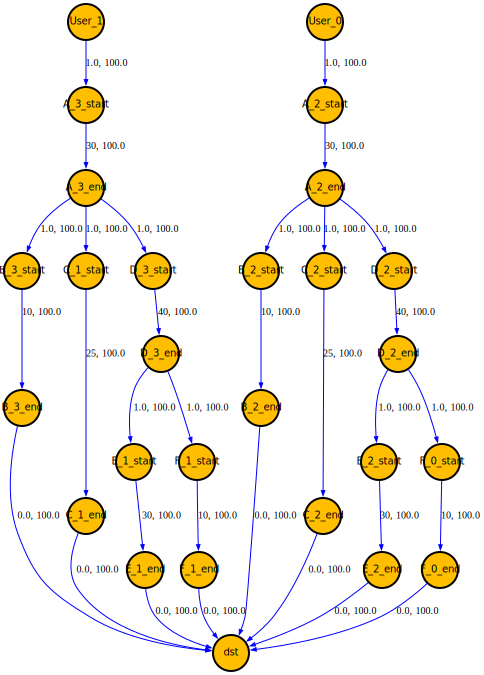

In [103]:
g_ = graphviz.Digraph()
# The node() method takes a name identifier as first argument and an optional label.
# The edge() method takes the names of start node and end node
# g_.size ="3,3"
print_all = True
node_pw = "2"
edge_pw = "1"
fs = "10"
edge_fs_0 = "10"
edge_fs_1 = "5"
fn="times bold italic"
edge_arrowsize="0.5"
edge_minlen="1"

if print_all:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
            g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
            g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.5")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
else:
    for k, v in latency.items():
        if k[0] in request_flow["From"].to_list() and k[1] in request_flow["To"].to_list():
            node_color = "#FFBF00"
        else:
            node_color = "#A7A4A4"
        g_.node(name=k[0], label=k[0], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True", width="0.75")
        g_.node(name=k[1], label=k[1], shape='circle', style='filled', fillcolor=node_color, penwidth=node_pw, fontsize=fs, fontname=fn, fixedsize="True")
        temp = request_flow[request_flow["From"]==k[0]]
        temp = temp[temp["To"]==k[1]]
        if len(temp) > 0:
            g_.edge(k[0], k[1], label=str(v)+", "+str(temp["Flow"].to_list()[0]), penwidth=edge_pw, style="filled", fontsize=edge_fs_0, color="blue", arrowsize=edge_arrowsize, minlen=edge_minlen)
        else:
            g_.edge(k[0], k[1], label=str(v), penwidth=edge_pw, style="dotted", fontsize=edge_fs_1, arrowhead="none", minlen=edge_minlen)
g_